# Lung segmentation from Chest X-Ray dataset

**About the data**:
- The dataset is made up of images and segmentated mask from two diffrent sources.
- There is a slight abnormality in naming convention of masks.
- Some images don't have their corresponding masks.
- Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.


## Take a look at the dataset

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/")
mask_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks/")

2024-04-18 17:47:35.663446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 17:47:35.663551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 17:47:35.802642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [3]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


Earlier I was going to train on the Shenzhen dataset while perform prediction on the Montgomery dataset. However, the nature of the data was diffrent in both the set. The images from Shenzhen dataset had smaller lung-to-image ratio as compared to the Montgomery dataset.

Thus, I am loading the two dataset seperately which I combined once I got to know about the disparity.

In [5]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [6]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i],cmap="gray")
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1],cmap="gray")
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2],cmap="gray")
        
        plt.show()

In [7]:
# Load training and testing data
dim = 512
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [01:08<00:00,  2.02it/s]


# Perform Sanity Check

It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

training set


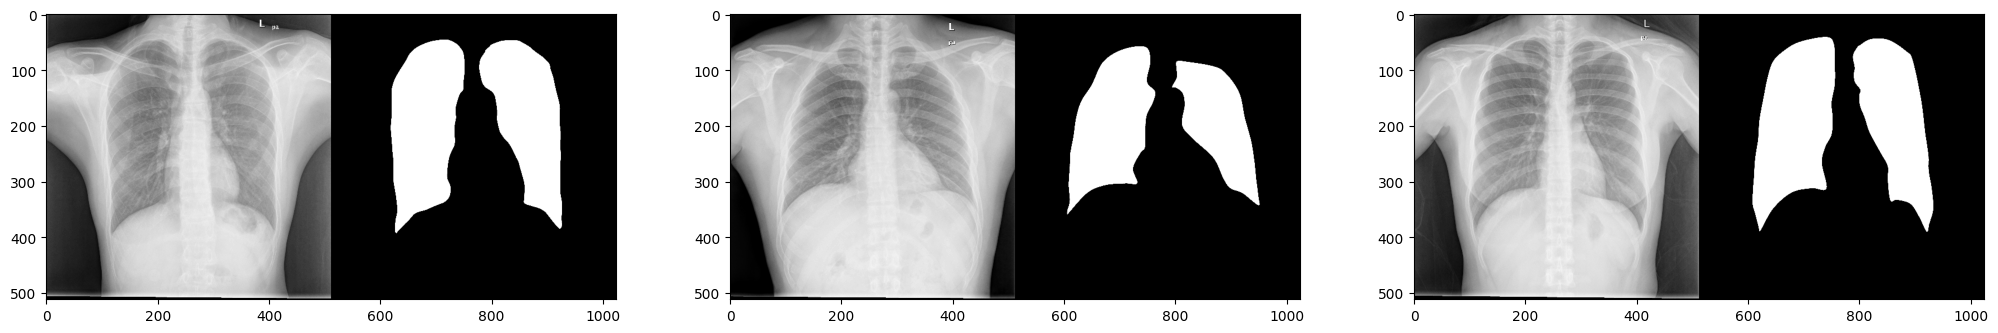

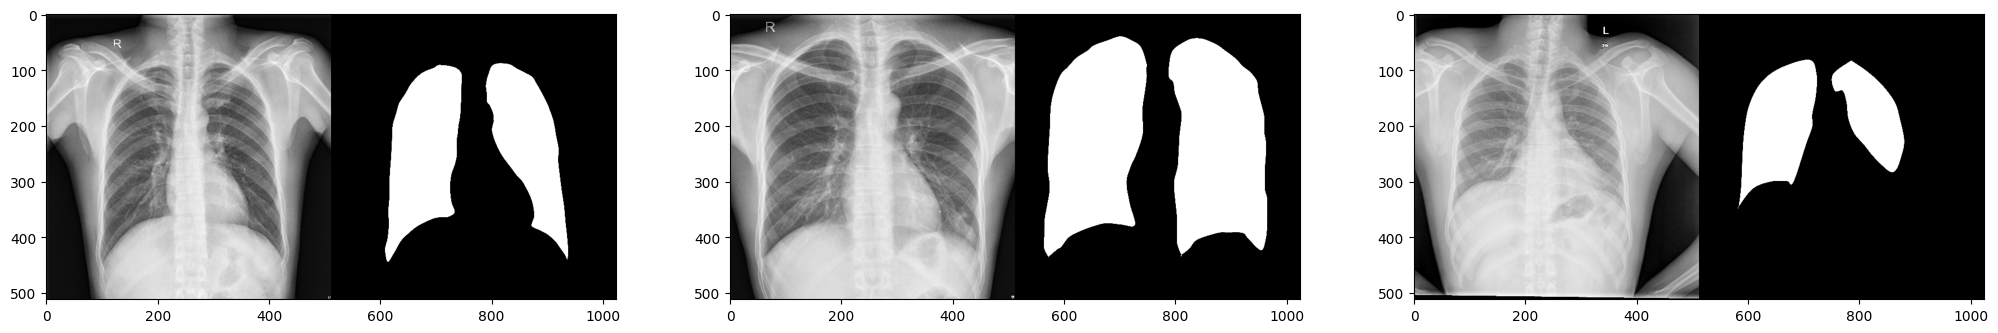

testing set


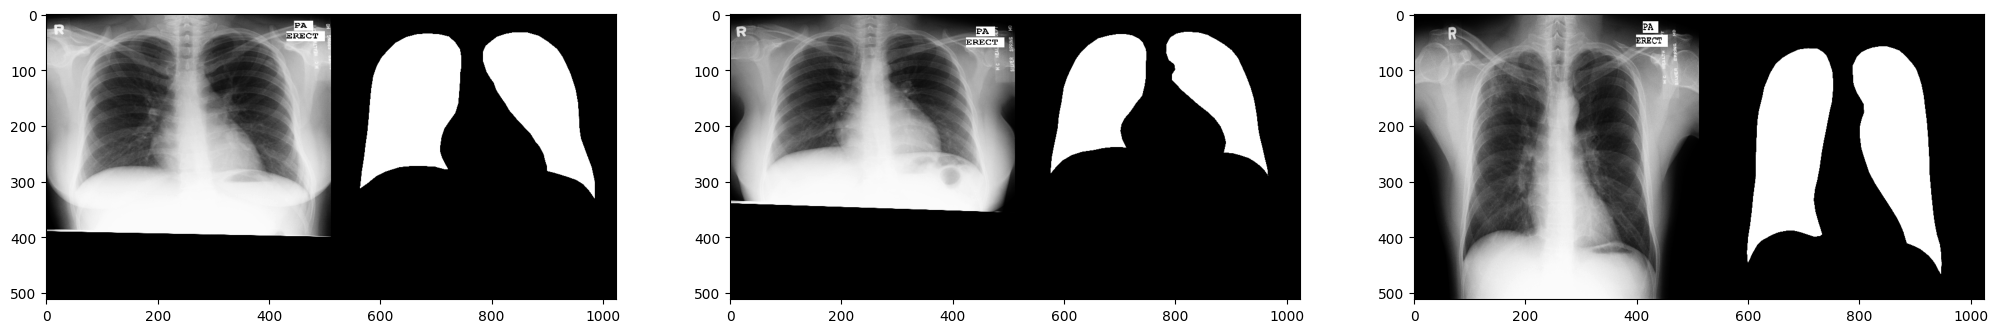

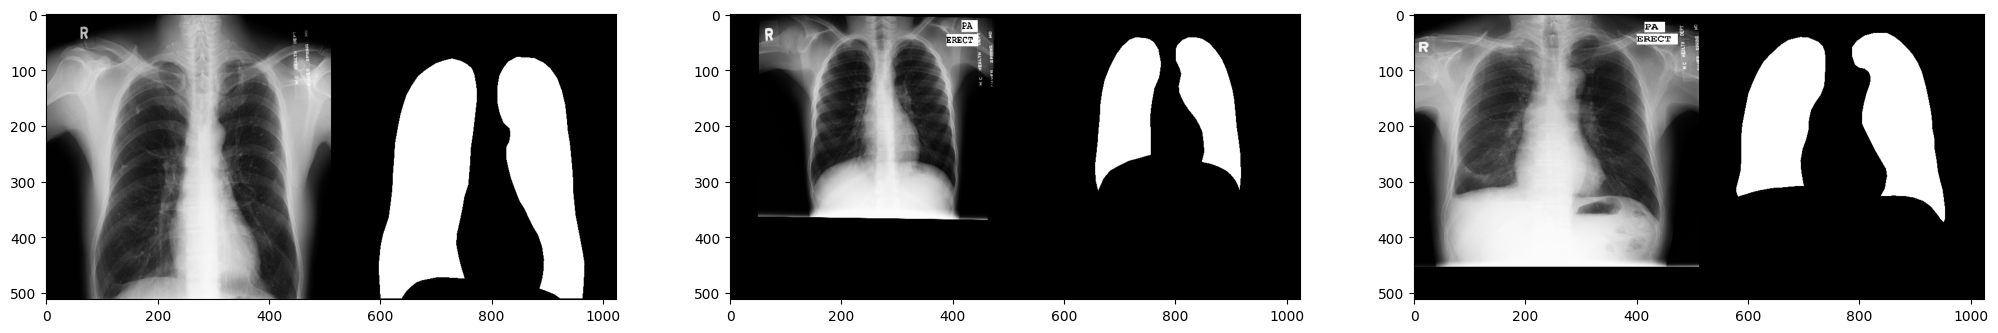

In [8]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [9]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [10]:
import os 
import sys 
import random 
import warnings
import numpy as np 
from time import time 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Activation, add, multiply, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K 
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
from tensorflow.keras import backend as K 
smooth = 1


def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

In [14]:
#!pip install -U --pre segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


#### Compile and train the Unet Model

In [15]:
model = sm.Unet('inceptionv3', classes=1, activation='sigmoid',input_shape=(512, 512, 1),encoder_weights=None)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#model = deeplab_plus()
# model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss,
#                   metrics=[dice_coef, 'binary_accuracy'])
#model.summary()

## Callbacks, Early Stopping and Reduced LR


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_3Dincepunetweights.keras".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [early, reduceLROnPlat,checkpoint]

In [18]:
images.shape

(704, 512, 512, 1)

In [19]:
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])



train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

In [ ]:
from IPython.display import clear_output





loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 4,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/50


I0000 00:00:1713463317.797586      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - binary_accuracy: 0.7741 - dice_coef: 0.5859 - iou_score: 0.7869 - loss: 0.4141
Epoch 1: val_loss improved from inf to 0.78022, saving model to cxr_reg_3Dincepunetweights.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 208s 623ms/step - binary_accuracy: 0.7750 - dice_coef: 0.5865 - iou_score: 0.7873 - loss: 0.4135 - val_binary_accuracy: 0.7408 - val_dice_coef: 0.2198 - val_iou_score: 0.7722 - val_loss: 0.7802 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - binary_accuracy: 0.9688 - dice_coef: 0.8191 - iou_score: 0.9170 - loss: 0.1809
Epoch 2: val_loss did not improve from 0.78022
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - binary_accuracy: 0.9688 - dice_coef: 0.8193 - iou_score: 0.9171 - loss: 0.1807 - val_binary_accuracy: 0.7400 - val_dice_coef: 0.1317 - val_iou_score: 0.8338 - val_loss: 0.8683 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - binary_accuracy: 0.9766 - dice_coef: 0.8

#### Train the model

I intially used a 60-40 train-test spit and got a loss of -0.97. However, the better way to do it is 80-10-10 train-test-validation spit. Below I am roughly doing the later.

## Plot the metric and evaluate 

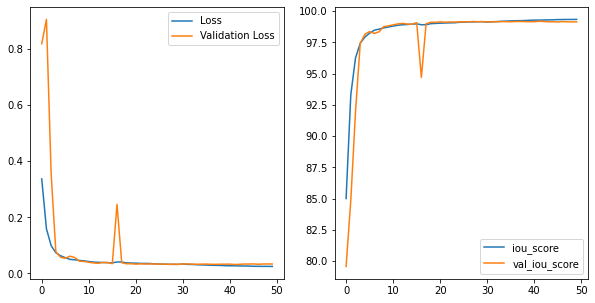

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['iou_score']), '-', 
         label = 'iou_score')
ax2.plot(100*np.array(loss_history.history['val_iou_score']), '-',
         label = 'val_iou_score')
ax2.legend()

## Test the model


3/3 [==============================] - 3s 415ms/step


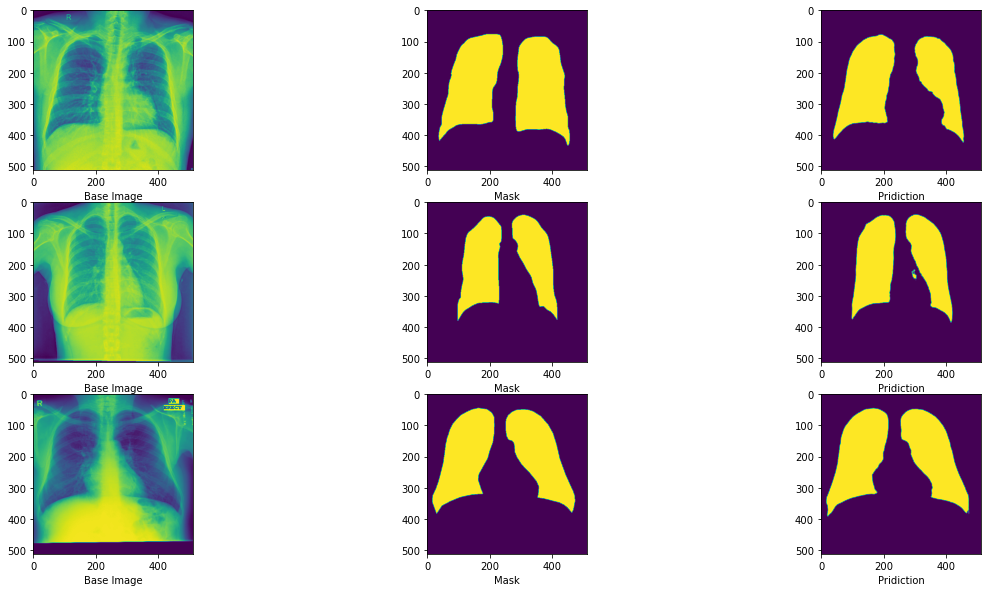

In [90]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
#validation_vol = np.rollaxis(validation_vol, 3, 1)

preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [64]:
from tensorflow.keras.models import load_model
#model = load_model('cxr_reg_atttweights.best.hdf5',custom_objects={'dice_coef_loss':                   
#dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})
model1 = sm.Unet('inceptionv3', classes=1, activation='sigmoid',input_shape=(512, 512, 1),encoder_weights=None)
model1.compile(optimizer=Adam(lr=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model1.load_weights("cxr_reg_incepunetweights.best.hdf5")

In [65]:
model2 = sm.Unet('seresnext50', classes=1, activation='sigmoid',input_shape=(512, 512, 1),encoder_weights=None)
model2.compile(optimizer=Adam(lr=1e-4), 
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model2.load_weights("cxr_reg_seunetpweights.best.hdf5")

In [66]:
model3 = sm.FPN('resnet50', classes=1, activation='sigmoid',input_shape=(512, 512, 1),encoder_weights=None)
model3.compile(optimizer=Adam(lr=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model3.load_weights("cxr_reg_fpnpweights.best.hdf5")

In [67]:
model4 = sm.Linknet('seresnext50', classes=1, activation='sigmoid',input_shape=(512, 512, 1),encoder_weights=None)
model4.compile(optimizer=Adam(lr=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model4.load_weights("cxr_reg_selinknetpweights.best.hdf5")

In [683]:
from glob import glob
file = glob("/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/*")
file

['/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Pneumonia',
 '/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Normal',
 '/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Covid-19']

In [96]:
import cv2
x = []
y = []
for i in tqdm(range(len(file))):
    s = file[i] + "/*"
    f = glob(s)
    print(s)
    name = file[i].split("/")[6]
    c = 0
    print(len(f))
    for j in f:
        img = cv2.imread(j,0)
        img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_NEAREST)
        img = (img-127.0)/127.0
        x.append(img)
        y.append(name)
        c += 1
    print(c)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Pneumonia/*

4273



 33%|███▎      | 1/3 [00:40<01:21, 40.64s/it]

4273

/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Normal/*

1583



 67%|██████▋   | 2/3 [01:13<00:36, 36.29s/it]

1583

/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Covid-19/*

4966


100%|██████████| 3/3 [02:31<00:00, 50.51s/it]

4966


In [40]:
file[1].split("/")[6]

'non-COVID'

In [24]:
import cv2
img = cv2.imread("/home/pranab_2021cs25/Shubham_Amity/Dataset_ViT/ViT_dataset/Covid-19/1622a51d-3ae2-466c-a5c8-304862f69eff.png")

In [26]:
img.shape

(1024, 1024, 3)

In [97]:
x = np.array(x)
x.shape

(10822, 512, 512)

In [98]:
y = np.array(y)
y= y.reshape(10822,1)

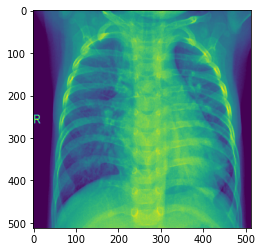

In [99]:
plt.imshow(x[0])

In [68]:
def AttnBlock2D(x, g, inter_channel, data_format='channels_first'):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):
    
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]
    
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = AttnBlock2D(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[3]], axis=3))
    
    concate = my_concat([up, layer])
    return concate
def att_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((1, 512, 512))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):

        # ENCODER
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_first', padding='same')(x)
        features = features * 2

    # BOTTLENECK
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # DECODER
    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    
    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)
    
    model = Model(inputs=inputs, outputs=conv7)

    return model
from tensorflow.keras.optimizers import Adam
model5 = att_unet(512, 512, n_label=1)

In [69]:
model5.compile(optimizer=Adam(lr=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model5.load_weights("cxr_reg_atttweights.best.hdf5")

In [70]:
from tensorflow.keras.models import load_model
model6 = load_model('cxr_reg_weights.best.hdf5',custom_objects={'dice_coef_loss':                   
dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

In [71]:
from tensorflow.keras.models import load_model
model7 = load_model('/home/pranab_2021cs25/Shubham_Amity/cxr_reg_weights.best.hdf5',custom_objects={'dice_coef_loss':                   
dice_coef_loss,'dice_coef':dice_coef,'iou_score':iou_score})

In [191]:
from glob import glob
xo = glob("/home/pranab_2021cs25/Shubham_Amity/ViT_datasets/ViT_dataset/Pneumonia/*")
#xl = cv2.imread("diagram2/original.jpg",0)


In [361]:
p = 8

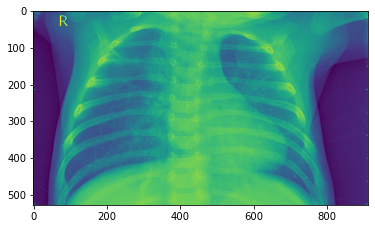

In [713]:
img = cv2.imread(xo[p],0)
plt.imshow(img)
img1 = cv2.imread(xo[p])
p += 1

In [714]:
img.shape

(528, 912)

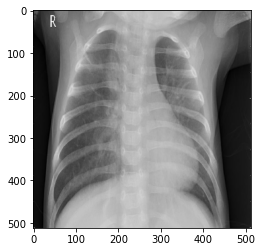

In [715]:
img2 = cv2.resize(img1, (512, 512), interpolation = cv2.INTER_NEAREST)

plt.imshow(img2)

In [716]:
img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_NEAREST)
imgl = (img-127.0)/127.0

In [717]:
matplotlib.image.imsave("diagram12/original.jpg", img2)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 115ms/step

1/1 [==============================] - 0s 169ms/step

1/1 [==============================] - 0s 165ms/step

1/1 [==============================] - 0s 89ms/step

1/1 [==============================] - 0s 153ms/step

1/1 [==============================] - 0s 67ms/step


  0%|          | 0/1 [00:06<?, ?it/s]


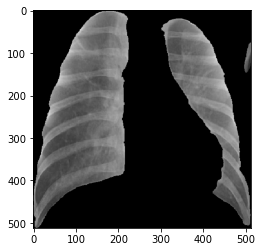

In [718]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
#     plt.imshow(img[0])
#     plt.show()
    img1 = np.rollaxis(img, 3, 1)
    pred5 = model5.predict(img1)
    pred1 = model1.predict(img)
    pred2 = model2.predict(img)
    pred3 = model3.predict(img)
    pred4 = model4.predict(img)
    #pred6 = model6.predict(img)
    pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    pred1 = pred1.reshape(512,512,1)
    pred2 = pred2.reshape(512,512,1)
    pred3 = pred3.reshape(512,512,1)
    pred4 = pred4.reshape(512,512,1)
    pred5 = pred5.reshape(512,512,1)
    #pred6 = pred6.reshape(512,512,1)
    pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred1[i][j]>=0.5 or pred2[i][j]>=0.5 or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512

#     #plt.imshow(new)
#     preds.append(new)
    #plt.imshow(new)
   # matplotlib.image.imsave("ensemble.jpg", new.reshape(512,512))
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0
    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/ensemble.jpg",new1.astype(np.uint8))
        
    break


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


  0%|          | 0/1 [00:02<?, ?it/s]


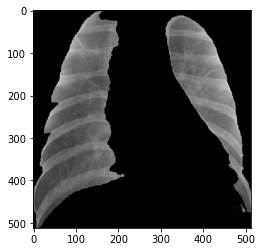

In [643]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
#     plt.imshow(img[0])
#     plt.show()
    img1 = np.rollaxis(img, 3, 1)
#     pred5 = model5.predict(img1)
    pred1 = model1.predict(img)
#     pred2 = model2.predict(img)
#     pred3 = model3.predict(img)
#     pred4 = model4.predict(img)
#     #pred6 = model6.predict(img)
#     pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    pred1 = pred1.reshape(512,512,1)
#     pred2 = pred2.reshape(512,512,1)
#     pred3 = pred3.reshape(512,512,1)
#     pred4 = pred4.reshape(512,512,1)
#     pred5 = pred5.reshape(512,512,1)
#     #pred6 = pred6.reshape(512,512,1)
#     pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred1[i][j]>=0.5: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512
    #new = new[n:m,c:f]
    #new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    plt.imshow(new)
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0
    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/inceptionunet.jpg",new1.astype(np.uint8))
    #matplotlib.image.imsave("diagram6/inceptionunet.jpg", new.reshape(512,512))
    break


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 215ms/step


  0%|          | 0/1 [00:02<?, ?it/s]


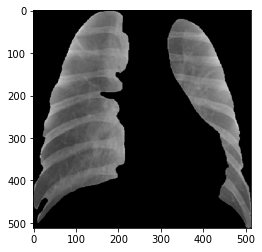

In [644]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
    img1 = np.rollaxis(img, 3, 1)
#     pred5 = model5.predict(img1)
    #pred1 = model1.predict(img)
    pred2 = model2.predict(img)
#     pred3 = model3.predict(img)
#     pred4 = model4.predict(img)
#     #pred6 = model6.predict(img)
#     pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    #pred1 = pred1.reshape(512,512,1)
    pred2 = pred2.reshape(512,512,1)
#     pred3 = pred3.reshape(512,512,1)
#     pred4 = pred4.reshape(512,512,1)
#     pred5 = pred5.reshape(512,512,1)
#     #pred6 = pred6.reshape(512,512,1)
#     pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred2[i][j]>=0.5: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512
   # new = new[n:m,c:f]
   # new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    #plt.imshow(new1)
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0

    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)                    
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/seresnxtunet.jpg",new1.astype(np.uint8))
    #matplotlib.image.imsave("diagram6/seresnxtunet.jpg", new.reshape(512,512))
    break


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 0/1 [00:01<?, ?it/s]


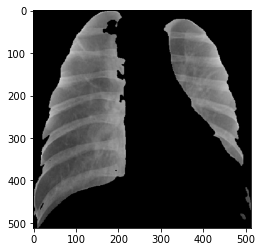

In [645]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
    img1 = np.rollaxis(img, 3, 1)
#     pred5 = model5.predict(img1)
    #pred1 = model1.predict(img)
    #pred2 = model2.predict(img)
    pred3 = model3.predict(img)
#     pred4 = model4.predict(img)
#     #pred6 = model6.predict(img)
#     pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    #pred1 = pred1.reshape(512,512,1)
    #pred2 = pred2.reshape(512,512,1)
    pred3 = pred3.reshape(512,512,1)
#     pred4 = pred4.reshape(512,512,1)
#     pred5 = pred5.reshape(512,512,1)
#     #pred6 = pred6.reshape(512,512,1)
#     pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred3[i][j]>=0.5: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512
    #new = new[n:m,c:f]
    #new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    plt.imshow(new)
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0
    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/resfpn.jpg",new1.astype(np.uint8))
   # matplotlib.image.imsave("diagram6/resfpn.jpg", new.reshape(512,512))
    break


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 97ms/step


  0%|          | 0/1 [00:01<?, ?it/s]


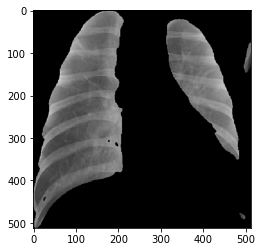

In [646]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
    img1 = np.rollaxis(img, 3, 1)
    pred5 = model5.predict(img1)
    #pred1 = model1.predict(img)
    #pred2 = model2.predict(img)
    #pred3 = model3.predict(img)
#     pred4 = model4.predict(img)
#     #pred6 = model6.predict(img)
#     pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    #pred1 = pred1.reshape(512,512,1)
    #pred2 = pred2.reshape(512,512,1)
    #pred3 = pred3.reshape(512,512,1)
#     pred4 = pred4.reshape(512,512,1)
    pred5 = pred5.reshape(512,512,1)
#     #pred6 = pred6.reshape(512,512,1)
#     pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred5[i][j]>=0.5: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512
    #new = new[n:m,c:f]
    #new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    plt.imshow(new)
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0
    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/attention.jpg",new1.astype(np.uint8))    
    #matplotlib.image.imsave("diagram6/attention.jpg", new.reshape(512,512))
    break


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


  0%|          | 0/1 [00:02<?, ?it/s]


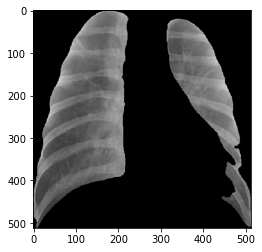

In [647]:
preds = []
img_x = imgl
for i in tqdm(range(1)):
    img = img_x.reshape(1,512,512,1)
    
    img1 = np.rollaxis(img, 3, 1)
    #pred5 = model5.predict(img1)
    #pred1 = model1.predict(img)
    #pred2 = model2.predict(img)
    #pred3 = model3.predict(img)
#     pred4 = model4.predict(img)
#     #pred6 = model6.predict(img)
    pred7 = model7.predict(img)


    #print(f'{pred.shape=, pred=}')
    #pred1 = pred1.reshape(512,512,1)
    #pred2 = pred2.reshape(512,512,1)
    #pred3 = pred3.reshape(512,512,1)
#     pred4 = pred4.reshape(512,512,1)
    #pred5 = pred5.reshape(512,512,1)
#     #pred6 = pred6.reshape(512,512,1)
    pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512), dtype=float)
    c = 512
    f = 0
    m = 512
    n = 0
    flag = 0
    img = img.reshape(512,512,1)
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if pred7[i][j]>=0.5: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = 0
                c = min(c,j)
                f = max(f,j)
                flag = 1
            else:
                count +=1
        if count == 512:
            if flag ==0:
                n = max(n,i)
            else:
                m = min(m,i)

    if m<280:
        m = 512
    if f<280:
        f = 512
   # new = new[n:m,c:f]
    #new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    plt.imshow(new)
    new1 = np.ones((512,512,3), dtype=int)
    for i in range(512):
        for j in range(512):
            if new[i][j] == 0:
                for k in range(3):
                    new1[i][j][k] = img2[i][j][k]
            else:
                for k in range(3):
                    new1[i][j][k] = 0
    new1 = new1[n:m,c:f]
    new1 = cv2.resize(new1, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imshow(new1.astype(np.uint8))
    matplotlib.image.imsave("diagram12/unet.jpg",new1.astype(np.uint8))
    #matplotlib.image.imsave("diagram6/unet.jpg", new.reshape(512,512))
    break

In [83]:
img = cv2.imread("/home/pranab_2021cs25/Shubham_Amity/chest_xray/diagram2/original.jpg")
b, g, r = cv2.split(img)
img = cv2.merge([r, g, b])

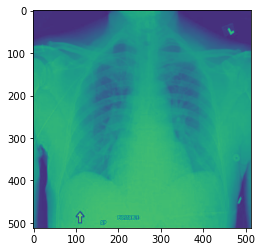

In [84]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
plt.imshow(img)

  0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

  0%|          | 0/1 [00:01<?, ?it/s]


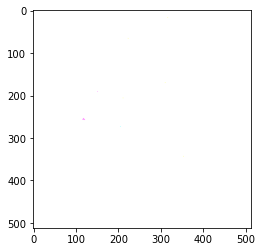

In [37]:
preds = []
img_x = img
for i in tqdm(range(1)):
    #img = img_x.reshape(1,512,512,1)
    
#     img1 = np.rollaxis(img, 3, 1)
#     #pred5 = model5.predict(img1)
#     #pred1 = model1.predict(img)
#     #pred2 = model2.predict(img)
#     #pred3 = model3.predict(img)
# #     pred4 = model4.predict(img)
# #     #pred6 = model6.predict(img)
#     pred7 = model7.predict(img)


#     #print(f'{pred.shape=, pred=}')
#     #pred1 = pred1.reshape(512,512,1)
#     #pred2 = pred2.reshape(512,512,1)
#     #pred3 = pred3.reshape(512,512,1)
# #     pred4 = pred4.reshape(512,512,1)
#     #pred5 = pred5.reshape(512,512,1)
# #     #pred6 = pred6.reshape(512,512,1)
#     pred7 = pred7.reshape(512,512,1)

    new = np.ones((512,512,3), dtype=float)
    #img = img.reshape(512,512,3)#
    for i in range(len(img)):
        count = 0
        for j in range(len(img)):
            if img[i][j][0]<100 or img[i][j][1]<100: #or pred2[i][j]>=0.5: #or pred3[i][j]>=0.5 or pred4[i][j]>=0.5 or pred5[i][j]>=0.5 or pred7[i][j]>=0.5:
                new[i][j] = img[i][j]
                
    new = cv2.resize(new, (512, 512), interpolation = cv2.INTER_NEAREST)
#     #plt.imshow(new)
#     preds.append(new)
    plt.imshow(new)
    #matplotlib.image.imsave("diagram6/unet.jpg", new.reshape(512,512))
    break

In [166]:
predsn = np.array(preds)
np.save("predsn",predsn)
np.save("y",y)

In [167]:
predsn.shape

(10820, 512, 512)

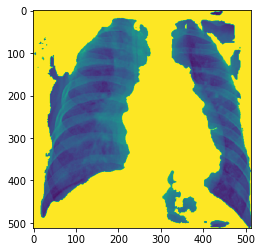

In [179]:
plt.imshow(predsn[2])

In [148]:
l =model7.predict(x[2].reshape(1,512,512,1))

1/1 [==============================] - 0s 41ms/step


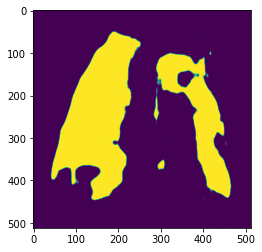

In [149]:
plt.imshow(l.reshape(512,512,1))

In [4]:
import numpy as np
predsn = np.load("predsn.npy")

In [5]:
#Prepare the data
num_classes = 3
input_shape = (224, 224, 1)
#os.listdir('/home/pranab_2021cs25/Shubham_Amity/Dataset_ViT/ViT_dataset')

In [9]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

In [7]:
from tqdm import tqdm
import matplotlib.image as imgo
import cv2
x_t = []
x_t1 = []
c = 0
for i in tqdm(range(len(predsn))):
    img = cv2.resize(predsn[i], (224, 224), interpolation = cv2.INTER_AREA)
    name = "new.jpg"
    imgo.imsave(name, img.reshape(224,224))
    c += 1
    img1 = cv2.imread(name)
    b, g, r = cv2.split(img1)
    img1 = cv2.merge([r, g, b])
    x_t.append(img)
    x_t1.append(img1)

100%|██████████| 10820/10820 [01:03<00:00, 170.83it/s]


In [8]:
x_t = np.array(x_t)
x_t1 = np.array(x_t1)

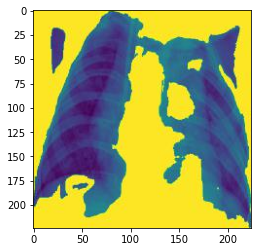

In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_t1[0])

In [10]:
del predsn

In [11]:
x_t.shape

(10820, 224, 224)

In [12]:
X = x_t.astype('float32')
X /= 255
del x_t
X1 = x_t1.astype('float32')
X1 /= 255
del x_t1

In [13]:
y = np.load("y.npy")

In [14]:
Y = []
for i in range(2,len(y)):
    if y[i] == "Pneumonia":
        Y.append(0)
    elif y[i] == "Covid-19":
        Y.append(1)
    elif y[i] == "Normal":
        Y.append(2)
    else:
        print(i)
Y = np.array(Y)
Y = Y.reshape(10820,1)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
del X
#from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.2, random_state=3)
del X1

In [16]:
x_train = x_train.reshape(8656,224,224,1)
x_test = x_test.reshape(2164,224,224,1)

In [17]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8656, 224, 224, 1) - y_train shape: (8656, 1)

x_test shape: (2164, 224, 224, 1) - y_test shape: (2164, 1)


In [18]:
#x_train, x_test = x_train / 255.0, x_test / 255.0
from tensorflow import keras
y_train = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test, num_classes)

In [19]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test1.shape}")

x_train shape: (8656, 224, 224, 1) - y_train shape: (8656, 3)

x_test shape: (2164, 224, 224, 1) - y_test shape: (2164, 3)


In [27]:
plt.figure(figsize=(224, 224))
for i in range(6):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [20]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 200
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-10-20 22:15:01.287618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38411 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224

Patch size: 16 X 16

Patches per image: 196

Elements per patch: 256


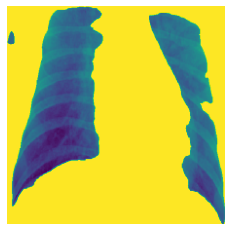

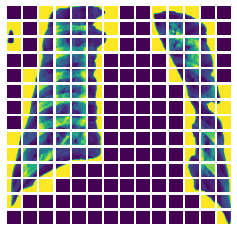

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [25]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [26]:
#Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [27]:
#compile and Run
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

#     history = model.fit(
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=200,
#         validation_split=0.1,
#         callbacks=[checkpoint_callback],
#     )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
#history = run_experiment(vit_classifier)

In [28]:
vit_classifier.load_weights("vit.hdf5")

In [29]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-5-accuracy"),
        ],
    )

In [30]:
y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

 7/68 [==>...........................] - ETA: 1s

2022-10-20 22:15:49.134081: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


68/68 [==============================] - 4s 19ms/step


In [31]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

68/68 [==============================] - 3s 23ms/step - loss: 0.1020 - accuracy: 0.9677 - top-5-accuracy: 0.9982

Test loss: 0.1

Test accuracy: 96.77%

Test top 5 accuracy: 99.82%


In [40]:
preds = vit_classifier.predict(x_test)

68/68 [==============================] - 1s 17ms/step


In [41]:
y_pred_classes = np.argmax(preds, axis=1)
y_pred_classes

array([0, 0, 0, ..., 1, 1, 0])

In [42]:
from tensorflow.keras.models import Model, load_model

model2 = load_model("resnetsegg.hdf5")
model2.evaluate(x_test1,y_test1)

2022-10-08 01:24:06.509205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100

2022-10-08 01:24:07.085385: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


68/68 [==============================] - 4s 27ms/step - loss: 0.2105 - accuracy: 0.9607


[0.21047118306159973, 0.9607208967208862]

In [46]:
preds2 = model2.predict(x_test1)
y_pred_classes2 = np.argmax(preds2, axis=1)


68/68 [==============================] - 2s 21ms/step


In [47]:
y_pred_classes2

array([0, 0, 0, ..., 1, 1, 0])

In [34]:
from keras.models import load_model
 
model3 = load_model("incepsegg.hdf5")
preds3 = model3.predict(x_test1)
y_pred_classes3 = np.argmax(preds3, axis=1)
model3.evaluate(x_test1,y_test1)

2022-10-20 22:21:23.544787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100

2022-10-20 22:21:24.431793: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


68/68 [==============================] - 7s 31ms/step

68/68 [==============================] - 3s 23ms/step - loss: 0.2303 - accuracy: 0.9469


[0.23028245568275452, 0.9468576908111572]

In [35]:
model4 = load_model("xpesegg.hdf5")
preds4 = model4.predict(x_test1)
y_pred_classes4 = np.argmax(preds4, axis=1)
model4.evaluate(x_test1,y_test1)

68/68 [==============================] - 3s 30ms/step

68/68 [==============================] - 3s 28ms/step - loss: 0.2676 - accuracy: 0.9566


[0.26758912205696106, 0.9565619230270386]

In [64]:
new = []
x = 0
for i in range(len(y_pred_classes)):
    new.append((y_pred_classes[i],y_pred_classes2[i],y_pred_classes4[i]))

In [65]:
new

[(0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (2, 2, 2),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (2, 2, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (2, 2, 2),
 (0, 0, 0),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (2, 2, 2),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (2, 2, 2),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 2, 0),
 (1, 1, 1),
 (0, 0, 0),
 (0, 2, 2),
 (0, 0, 0),
 (1, 0, 1),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (2, 2, 2),
 (0, 0, 0),
 (0, 0, 0),
 (2, 2, 2),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 2),
 (0, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (1, 1, 1),
 (2, 2, 2),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (0, 0, 0),
 (0,

In [66]:
def findCandidate(A):
    maj_index = 0
    count = 1
    for i in range(len(A)):
        if A[maj_index] == A[i]:
            count += 1
        else:
            count -= 1
        if count == 0:
            maj_index = i
            count = 1
    return A[maj_index]
 
# Function to check if the candidate occurs more than n/2 times
 
def isMajority(A, cand):
    count = 0
    for i in range(len(A)):
        if A[i] == cand:
            count += 1
    if count > len(A)/2:
        return True
    else:
        return False
 
# Function to print Majority Element
 
def printMajority(A):
    # Find the candidate for Majority
    cand = findCandidate(A)
 
    # Print the candidate if it is Majority
    if isMajority(A, cand) == True:
        return cand
    else:
        return 10

In [67]:
y_test[1843]

array([1])

In [68]:
new1 = []

for i in range(len(new)):
    x = printMajority(new[i])
    if x == 10:
        print(i)
        new1.append(1)
    else:
        new1.append(x)

1748


In [89]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test, new1)
accuracy

0.9704251386321626

In [85]:
new1[154]

0

In [84]:
y_test[154]

array([2])

In [88]:
new1[154] = 0


In [73]:
for i in range(2164):
    if y_test[i] != new1[i]:
        print(i)

19

80

154

164

216

250

310

341

404

434

436

442

481

540

548

638

678

711

730

739

746

863

866

884

931

939

969

975

1065

1092

1127

1198

1199

1222

1243

1270

1311

1320

1345

1413

1424

1446

1462

1498

1559

1578

1586

1656

1675

1690

1704

1748

1767

1770

1818

1828

1874

1883

1940

2018

2041

2056

2070

2112

2144

2153


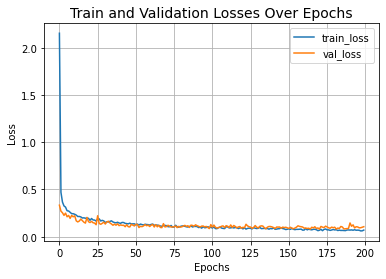

In [43]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


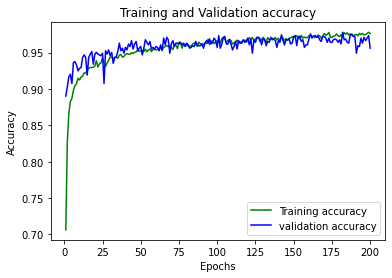

In [44]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

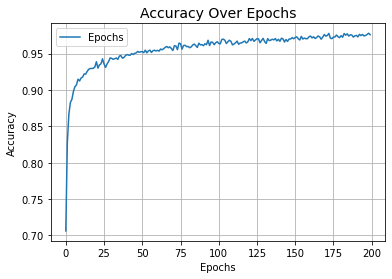

In [45]:
plt.plot(history.history["accuracy"], label="Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [46]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

68/68 [==============================] - 1s 17ms/step - loss: 0.1020 - accuracy: 0.9677 - top-5-accuracy: 0.9982

Test loss: 0.1

Test accuracy: 96.77%

Test top 5 accuracy: 99.82%


In [93]:
from sklearn.metrics import classification_report, confusion_matrix

#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
confusion_matrix(y_test, y_pred_classes)

array([[ 785,    9,   16],
       [   9, 1006,    1],
       [  32,    3,  303]])

In [56]:
#Configure the hyperparameters
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size
input_shape = (224,224,3)

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 100
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1
#Helper functions, We create two helper functions to help us get a sequence of patches from the image, merge patches, and apply dropout.
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x

#Setup

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output
#Window based multi-head self-attention, Usually Transformers perform global self-attention,where the relationships between a token and all other tokens are computed. 
#The global computation leads to quadratic complexity with respect to the number of tokens. 
#Here, as the original paper suggests, we compute self-attention within local windows, in a non-overlapping manner.
#Global self-attention leads to quadratic computational complexity in the number of patches, whereas window-based self-attention leads to linear complexity and is easily scalable.
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
#The complete Swin Transformer model
#Finally, we put together the complete Swin Transformer by replacing the standard multi-head attention (MHA) with shifted windows attention. As suggested in the original paper, we create a model comprising of a shifted window-based MHA layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying LayerNormalization before each MSA layer and each MLP, and a residual connection after each of these layers.
#Notice that we only create a simple MLP with 2 Dense and 2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is quite standard in the literature. However in this paper the authors use a 2-layer MLP with GELU nonlinearity in between.
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x
#Model training and evaluation
#Extract and embed patches
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [57]:
#Build the model
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3, activation="softmax")(x)

In [54]:
modelx = load_model("coat3.hdf5")
predsx = modelx.predict(x_test1)
y_pred_classesx = np.argmax(predsx, axis=1)
modelx.evaluate(x_test1,y_test)

68/68 [==============================] - 18s 203ms/step

68/68 [==============================] - 16s 198ms/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9640


[0.14295391738414764, 0.9639556407928467]

Text(21.499999999999993, 0.5, 'True')

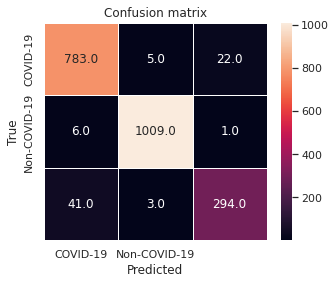

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ["COVID-19", "Non-COVID-19"]
#Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classesx)
fig, ax = plt.subplots(figsize=(5,4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax,fmt = ".1f",xticklabels=class_names,yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

In [44]:
y_pred = vit_classifier.predict(x_test)
#print(y_pred)
y_pred=np.round(abs(y_pred))
#print(y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

68/68 [==============================] - 1s 17ms/step


NameError: name 'classification_report' is not defined

In [176]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    print("1")
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    print("2")
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    print("3")
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [177]:
import tensorflow as tf
# Remove last layer's softmax
model.layers[-1].activation = None
#print(x_train[1050].shape)
# Print what the top predicted class is
preds = model.predict(img.reshape(1,224,224,1))
#print("Predicted:", decode_predictions(preds, top=1)[0])
print("6")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="block5_conv3")

# Display heatmap
plt.imshow(heatmap)
plt.show()

ValueError: in user code:

    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/pranab_2021cs25/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_2" (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 224, 1)
    
    Call arguments received by layer "model_2" (type Functional):
      • inputs=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
      • training=False
      • mask=None


In [19]:
model.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 56, 56, 1

In [23]:
from tensorflow.keras.applications import VGG16, Xception
model=Xception(weights="imagenet",include_top=False,input_shape=(224, 224, 3))

2022-10-03 18:04:28.528913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37832 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0

2022-10-03 18:04:28.531953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37832 MB memory:  -> device: 1, name: A100-PCIE-40GB, pci bus id: 0000:e1:00.0, compute capability: 8.0


In [24]:
from tensorflow.keras import Model
from tensorflow.keras import layers
x = layers.Flatten()(model.output)
#y = layers.Dropout(0.3)(x)
output = layers.Dense(3, activation='softmax')(x)
model = Model(model.input, output)

In [103]:
from keras.models import load_model
# model = load_model("vgg16b.hdf5")

In [26]:
opt = keras.optimizers.Adam(learning_rate = 1e-5)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
history1 = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=200,
        validation_split=0.15,
        #callbacks=[checkpoint_callback],
    )


Epoch 1/200


2022-10-03 18:04:42.434947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100

2022-10-03 18:04:43.288273: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory

2022-10-03 18:04:44.897322: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


58/58 [==============================] - 68s 1s/step - loss: 0.5017 - accuracy: 0.8083 - val_loss: 0.6513 - val_accuracy: 0.7698

Epoch 2/200

58/58 [==============================] - 63s 1s/step - loss: 0.1774 - accuracy: 0.9414 - val_loss: 0.4147 - val_accuracy: 0.8568

Epoch 3/200

58/58 [==============================] - 57s 985ms/step - loss: 0.1037 - accuracy: 0.9683 - val_loss: 0.2510 - val_accuracy: 0.9007

Epoch 4/200

58/58 [==============================] - 54s 932ms/step - loss: 0.0654 - accuracy: 0.9811 - val_loss: 0.1766 - val_accuracy: 0.9353

Epoch 5/200

58/58 [==============================] - 53s 906ms/step - loss: 0.0429 - accuracy: 0.9894 - val_loss: 0.1504 - val_accuracy: 0.9507

Epoch 6/200

58/58 [==============================] - 53s 923ms/step - loss: 0.0277 - accuracy: 0.9962 - val_loss: 0.1303 - val_accuracy: 0.9592

Epoch 7/200

58/58 [==============================] - 53s 917ms/step - loss: 0.0186 - accuracy: 0.9989 - val_loss: 0.1332 - val_accuracy: 0.958

In [175]:
model = load_model("vgg_nonseg.hdf5")

In [130]:
_,accuracy = model.evaluate(x_test, y_test1)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

68/68 [==============================] - 2s 25ms/step - loss: 0.3910 - accuracy: 0.8785

Test accuracy: 87.85%


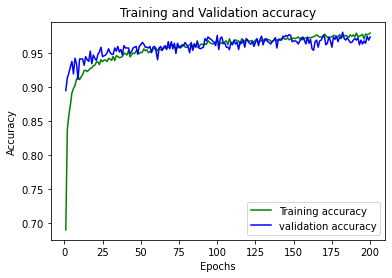

In [33]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

In [51]:
hist_df.to_csv('vit_seg.csv')

In [50]:
hist_df["val_accuracy"].max()

0.9780600666999817

68/68 [==============================] - 1s 18ms/step


Text(30.5, 0.5, 'True')

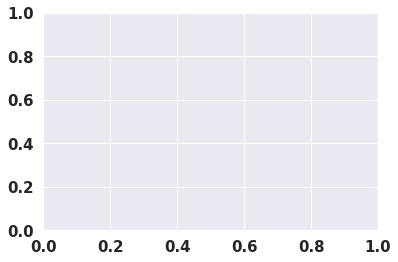

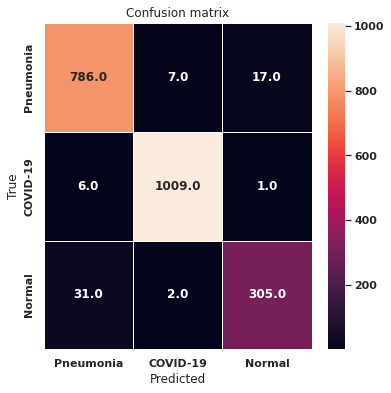

In [93]:
from sklearn.metrics import confusion_matrix
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.rcParams.update({'font.size': 19})
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 17}
plt.rc('font', **font)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
import seaborn as sns
y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ["Pneumonia", "COVID-19", "Normal"]
#Print confusion matrix
cm = confusion_matrix(y_test, new1)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax,fmt = ".1f",xticklabels=class_names,yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


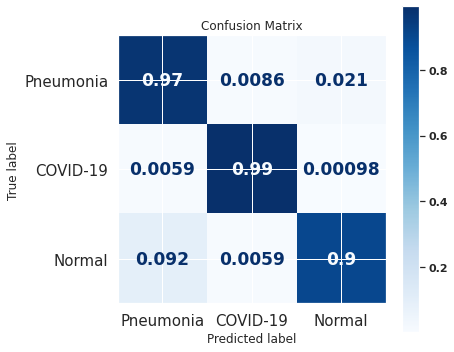

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(6, 6))
#plt.rcParams.update({'font.size': 19})
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 17}
plt.rc('font', **font)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.title(fontsize=15)
cm = confusion_matrix(y_test, new1, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Pneumonia", "COVID-19", "Normal"])
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.savefig('cm_vgg_seg.jpg')
plt.show()


In [42]:
model.save("xpesegg.hdf5")

In [1]:
import pandas as pd
res = pd.read_csv("Res_seg.csv")

In [2]:
vgg = pd.read_csv("vgg_seg.csv")

In [3]:
xpe = pd.read_csv("xpe_seg.csv")

In [4]:
incep = pd.read_csv("incep_seg.csv")
history = pd.read_csv("vit_seg.csv")

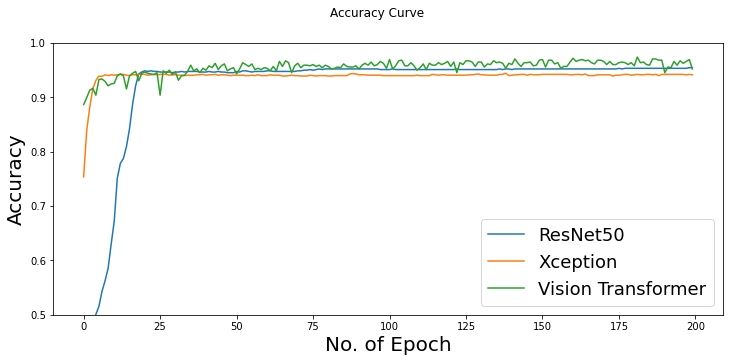

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib

fig = plt.figure(figsize=(12,5))

fig.suptitle("Accuracy Curve")
ax1 = fig.add_subplot()

#ax1.plot(incep["val_accuracy"])

#quadratic = [num**2 for num in x]
#cubic = [num**3 for num in x
#ax1.plot(res["accuracy"])
ax1.plot(res["val_accuracy"]*0.99)

#ax1.plot(xpe["accuracy"])
ax1.plot(xpe["val_accuracy"]*0.9792)

#ax1.plot(history.history["accuracy"])
ax1.plot(history["val_accuracy"]*0.996)

#ax1.plot(vgg["accuracy"])
#ax1.plot(vgg["val_accuracy"]*0.97)

plt.xlabel("No. of Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize = 20)

plt.legend(["ResNet50","Xception","Vision Transformer"], loc ="lower right", prop={'size': 18})
# ax1.legend(loc = 'upper left')
# ax2.legend(loc = 'upper right')
plt.ylim(0.5,1.0)

plt.show()

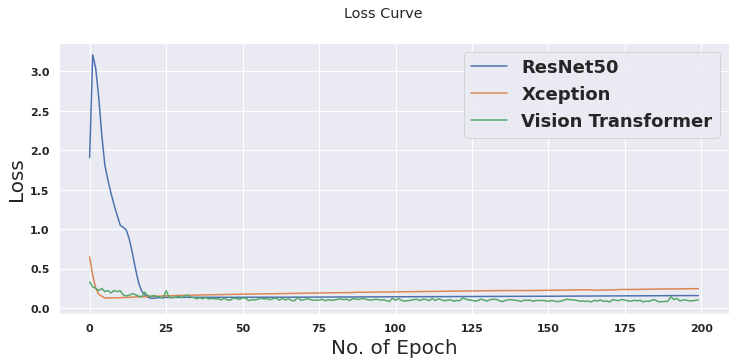

In [99]:
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib

fig = plt.figure(figsize=(12,5))

fig.suptitle("Loss Curve")
ax1 = fig.add_subplot()

#ax1.plot(incep["val_loss"])

#quadratic = [num**2 for num in x]
#cubic = [num**3 for num in x
#ax1.plot(res["accuracy"])
ax1.plot(res["val_loss"])

#ax1.plot(xpe["accuracy"])
ax1.plot(xpe["val_loss"])

#ax1.plot(history.history["accuracy"])
ax1.plot(history["val_loss"])

#ax1.plot(vgg["accuracy"])
#ax1.plot(vgg["val_accuracy"]*0.97)

plt.xlabel("No. of Epoch", fontsize=20)
plt.ylabel("Loss", fontsize = 20)

plt.legend(["ResNet50","Xception","Vision Transformer"], loc ="upper right", prop={'size': 18})
# ax1.legend(loc = 'upper left')
# ax2.legend(loc = 'upper right')

plt.show()